<a href="https://colab.research.google.com/github/AjinthaSivam/tamil-grapheme-gpt/blob/main/tamil_grapheme_gpt_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tamil Grapheme-Level Decoder-Only Transformer

This notebook implements a grapheme-level (instead of character-level) transformer for Tamil text generation.
Grapheme tokenization treats Tamil consonant-vowel combinations as single units, which is more linguistically appropriate.

In [2]:
# Install required packages
!pip install torch datasets grapheme

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for grapheme: filename=grapheme-0.6.0-py3-none-any.whl size=210082 sha256=d331fcc8e9654d1a3ae970e463d8551745cf787fa7d298c9596e9a517b2ab9b2
  Stored in directory: /root/.cache/pip/wheels/5b/aa/3b/d94434910f5e19ac7f8aa6523d74a46fe06bfcbc7e4b26caf6
Successfully built grapheme


In [3]:
import json
import os
import torch
import torch.nn as nn
from torch.nn import functional as F
import grapheme
from pathlib import Path
from tqdm import tqdm
import random

## Configuration

In [4]:
# Hyperparameters
batch_size = 64
block_size = 256
max_iters = 30000
eval_interval = 500
learning_rate = 2e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 96
n_head = 3
n_layer = 4
dropout = 0.2

# Set random seed for reproducibility
torch.manual_seed(1337)

print(f"Using device: {device}")

Using device: cuda


## Mount Google Drive and Extract Data

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import zipfile
import os

# === CONFIGURATION: Choose your setup ===
# Option 1: If your data is in a zip file
ZIP_PATH = '/content/drive/MyDrive/tamil_data/lk_news_2/v2_split_2024.zip'

# Option 2: If your data is already in a folder (not zipped)
# Uncomment the line below and comment out the extraction code if not using zip
# DATA_DIR = '/content/drive/MyDrive/tamil_data/lk_news/tamilmirror/2024'

# Directory to extract to (in Colab's local storage for faster access)
EXTRACT_DIR = '/content/tamil_data_extracted/2024'

# Check if zip file exists and extract
if os.path.exists(ZIP_PATH):
    print(f"Found zip file: {ZIP_PATH}")

    # Create extraction directory
    os.makedirs(EXTRACT_DIR, exist_ok=True)

    # Check if already extracted
    if len(os.listdir(EXTRACT_DIR)) > 0:
        print(f"Data already extracted to {EXTRACT_DIR}")
    else:
        print(f"Extracting {ZIP_PATH}...")
        with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
            # Show progress
            members = zip_ref.namelist()
            print(f"Found {len(members)} files in archive")
            zip_ref.extractall(EXTRACT_DIR)
        print(f"Extraction complete!")

    DATA_DIR = f'{EXTRACT_DIR}/2024'

else:
    print(f"Zip file not found at {ZIP_PATH}")
    print("Please update ZIP_PATH or DATA_DIR variable with the correct path")
    # If zip doesn't exist, try using direct folder path
    DATA_DIR = '/content/drive/MyDrive/tamil_data/lk_news/tamilmirror/2024'

print(f"\nUsing data directory: {DATA_DIR}")

# Verify the directory exists and has files
if os.path.exists(DATA_DIR):
    files = [f for f in os.listdir(DATA_DIR) if f.endswith('.json')]
    print(f"Number of JSON files found: {len(files)}")
    if len(files) > 0:
        print(f"Sample files: {files[:5]}")
    else:
        print("WARNING: No JSON files found in directory!")
else:
    print(f"ERROR: Directory {DATA_DIR} does not exist!")

Found zip file: /content/drive/MyDrive/tamil_data/lk_news_2/v2_split_2024.zip
Extracting /content/drive/MyDrive/tamil_data/lk_news_2/v2_split_2024.zip...
Found 8895 files in archive
Extraction complete!

Using data directory: /content/tamil_data_extracted/2024/2024
Number of JSON files found: 8894
Sample files: ['2024-03-04-tamilmirrorlk-6c979f2c_split.json', '2024-02-02-tamilmirrorlk-1daea565_split.json', '2024-01-20-tamilmirrorlk-c8ae20ee_split.json', '2024-10-07-tamilmirrorlk-e51800c3_split.json', '2024-05-27-tamilmirrorlk-9fb2cbfa_split.json']


## Data Loading and Grapheme Tokenization

In [7]:
def load_json_texts(data_dir):
    """
    Load all JSON files from a specified directory and extract the 'text' field.
    Handles the actual dataset structure where JSON contains:
    {
        "sentences": [
            {"id": 1, "text": "..."},
            {"id": 2, "text": "..."}
        ]
    }
    """
    all_texts = []
    json_files = list(Path(data_dir).glob('*.json'))

    print(f"Found {len(json_files)} JSON files")

    for json_file in tqdm(json_files, desc="Loading JSON files"):
        try:
            with open(json_file, 'r', encoding='utf-8') as f:
                data = json.load(f)

                # Extract text from sentences
                if 'sentences' in data and isinstance(data['sentences'], list):
                    for sentence in data['sentences']:
                        if isinstance(sentence, dict) and 'text' in sentence:
                            text = sentence['text'].strip()
                            if text:
                                all_texts.append(text)
        except Exception as e:
            print(f"Error loading {json_file}: {e}")
            continue

    print(f"Loaded {len(all_texts)} text samples")
    return all_texts

# Load the data
texts = load_json_texts(DATA_DIR)
full_text = '\n'.join(texts)
print(f"Total characters: {len(full_text)}")
print(f"Sample text: {full_text[:200]}")

Found 8894 JSON files


Loading JSON files: 100%|██████████| 8894/8894 [00:00<00:00, 20449.56it/s]

Loaded 60462 text samples
Total characters: 8011303
Sample text: காதலனுக்காக சிறுமி செய்த செயல்; இறுதியில் இருவரும் கைது
வாதுவை - பொஹத்தரமுல்ல கடற்கரை பகுதியில் போதைப்பொருளுடன் 17 வயது சிறுமியும் அவரது 30 வயதான காதலரும் கைது செய்யப்பட்டுள்ளனர்.
சந்தேக நபரான சிறுமி 


In [8]:
# Grapheme tokenization
def text_to_graphemes(text):
    """Convert text to a list of graphemes"""
    return list(grapheme.graphemes(text))

def graphemes_to_text(graphemes):
    """Convert list of graphemes back to text"""
    return ''.join(graphemes)

# Convert entire text to graphemes
print("Converting text to graphemes...")
all_graphemes = text_to_graphemes(full_text)
print(f"Total graphemes: {len(all_graphemes)}")

# Build vocabulary from graphemes
unique_graphemes = sorted(list(set(all_graphemes)))
vocab_size = len(unique_graphemes)
print(f"Vocabulary size (unique graphemes): {vocab_size}")
print(f"Sample graphemes: {unique_graphemes[100:120]}")

Converting text to graphemes...
Total graphemes: 5175615
Vocabulary size (unique graphemes): 454
Sample graphemes: ['ஆ', 'ஆா்', 'இ', 'இ்', 'ஈ', 'உ', 'ஊ', 'எ', 'எ்', 'ஏ', 'ஐ', 'ஒ', 'ஓ', 'ஔ', 'ஔி', 'க', 'கா', 'காெ', 'கா்', 'கி']


In [9]:
# Create grapheme-to-index and index-to-grapheme mappings
gtoi = {g: i for i, g in enumerate(unique_graphemes)}
itog = {i: g for i, g in enumerate(unique_graphemes)}

# Encode and decode functions
def encode(text):
    """Convert text to list of grapheme indices"""
    graphemes = text_to_graphemes(text)
    return [gtoi[g] for g in graphemes]

def decode(indices):
    """Convert list of grapheme indices back to text"""
    graphemes = [itog[i] for i in indices]
    return graphemes_to_text(graphemes)

# Test encoding and decoding
test_text = texts[0][:100] if texts else "வணக்கம்"
encoded = encode(test_text)
decoded = decode(encoded)
print(f"Original: {test_text}")
print(f"Encoded (first 20): {encoded[:20]}")
print(f"Decoded: {decoded}")
print(f"Match: {test_text == decoded}")

Original: காதலனுக்காக சிறுமி செய்த செயல்; இறுதியில் இருவரும் கைது
Encoded (first 20): [116, 201, 349, 249, 133, 116, 115, 1, 140, 337, 282, 1, 144, 315, 201, 1, 144, 297, 365, 28]
Decoded: காதலனுக்காக சிறுமி செய்த செயல்; இறுதியில் இருவரும் கைது
Match: True


In [10]:
# Encode entire dataset
print("Encoding entire dataset...")
data = torch.tensor(encode(full_text), dtype=torch.long)
print(f"Data tensor shape: {data.shape}")

# Train-validation split
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]
print(f"Train size: {len(train_data)}, Val size: {len(val_data)}")

Encoding entire dataset...
Data tensor shape: torch.Size([5175615])
Train size: 4658053, Val size: 517562


## Data Batch Generation

In [11]:
def get_batch(split):
    """Generate a small batch of data of inputs x and targets y"""
    data_split = train_data if split == 'train' else val_data
    ix = torch.randint(len(data_split) - block_size, (batch_size,))
    x = torch.stack([data_split[i:i+block_size] for i in ix])
    y = torch.stack([data_split[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    """Estimate loss on train and val sets"""
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

## Model Architecture

In [12]:
class Head(nn.Module):
    """One head of self-attention"""

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)   # (B, T, head_size)
        q = self.query(x) # (B, T, head_size)

        # Compute attention scores
        wei = q @ k.transpose(-2, -1) * (C ** -0.5)  # (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)

        # Weighted aggregation of values
        v = self.value(x)  # (B, T, head_size)
        out = wei @ v      # (B, T, head_size)
        return out


class MultiHeadAttention(nn.Module):
    """Multiple heads of self-attention in parallel"""

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out


class FeedFoward(nn.Module):
    """A simple linear layer followed by a non-linearity"""

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)


class Block(nn.Module):
    """Transformer block: communication followed by computation"""

    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x


class GraphemeGPT(nn.Module):
    """Grapheme-level language model"""

    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx)  # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device))  # (T,C)
        x = tok_emb + pos_emb  # (B,T,C)
        x = self.blocks(x)     # (B,T,C)
        x = self.ln_f(x)       # (B,T,C)
        logits = self.lm_head(x)  # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # Crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # Get the predictions
            logits, loss = self(idx_cond)
            # Focus only on the last time step
            logits = logits[:, -1, :]  # becomes (B, C)
            # Apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1)  # (B, C)
            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (B, 1)
            # Append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1)  # (B, T+1)
        return idx

# Create model
model = GraphemeGPT()
model = model.to(device)

# Print the number of parameters in the model
print(f"Model parameters: {sum(p.numel() for p in model.parameters()) / 1e6:.2f}M")
print(model)

Model parameters: 0.56M
GraphemeGPT(
  (token_embedding_table): Embedding(454, 96)
  (position_embedding_table): Embedding(256, 96)
  (blocks): Sequential(
    (0): Block(
      (sa): MultiHeadAttention(
        (heads): ModuleList(
          (0-2): 3 x Head(
            (key): Linear(in_features=96, out_features=32, bias=False)
            (query): Linear(in_features=96, out_features=32, bias=False)
            (value): Linear(in_features=96, out_features=32, bias=False)
            (dropout): Dropout(p=0.2, inplace=False)
          )
        )
        (proj): Linear(in_features=96, out_features=96, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (ffwd): FeedFoward(
        (net): Sequential(
          (0): Linear(in_features=96, out_features=384, bias=True)
          (1): ReLU()
          (2): Linear(in_features=384, out_features=96, bias=True)
          (3): Dropout(p=0.2, inplace=False)
        )
      )
      (ln1): LayerNorm((96,), eps=1e-05, elementwise

## Training

In [13]:
# Create optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# Training loop
best_val_loss = float('inf')
train_losses = []
val_losses = []

print("Starting training...")
for iter in range(max_iters):

    # Every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        train_losses.append(losses['train'])
        val_losses.append(losses['val'])
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

        # Save best model
        if losses['val'] < best_val_loss:
            best_val_loss = losses['val']
            torch.save({
                'iter': iter,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': losses['train'],
                'val_loss': losses['val'],
                'vocab_size': vocab_size,
                'gtoi': gtoi,
                'itog': itog,
                'unique_graphemes': unique_graphemes
            }, 'best_grapheme_model.pt')
            print(f"  → Saved best model (val loss: {best_val_loss:.4f})")

    # Sample a batch of data
    xb, yb = get_batch('train')

    # Evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

print(f"\nTraining complete! Best validation loss: {best_val_loss:.4f}")

Starting training...
step 0: train loss 6.3143, val loss 6.3141
  → Saved best model (val loss: 6.3141)
step 500: train loss 3.0806, val loss 3.0701
  → Saved best model (val loss: 3.0701)
step 1000: train loss 2.8935, val loss 2.8897
  → Saved best model (val loss: 2.8897)
step 1500: train loss 2.8212, val loss 2.8159
  → Saved best model (val loss: 2.8159)
step 2000: train loss 2.7660, val loss 2.7636
  → Saved best model (val loss: 2.7636)
step 2500: train loss 2.6812, val loss 2.6815
  → Saved best model (val loss: 2.6815)
step 3000: train loss 2.5815, val loss 2.5827
  → Saved best model (val loss: 2.5827)
step 3500: train loss 2.4887, val loss 2.4917
  → Saved best model (val loss: 2.4917)
step 4000: train loss 2.4080, val loss 2.4157
  → Saved best model (val loss: 2.4157)
step 4500: train loss 2.3334, val loss 2.3358
  → Saved best model (val loss: 2.3358)
step 5000: train loss 2.2722, val loss 2.2773
  → Saved best model (val loss: 2.2773)
step 5500: train loss 2.2120, val los

## Text Generation

In [14]:
# Load best model
checkpoint = torch.load('best_grapheme_model.pt', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"Loaded model from iteration {checkpoint['iter']}")
print(f"Val loss: {checkpoint['val_loss']:.4f}")

Loaded model from iteration 29999
Val loss: 1.6372


In [15]:
# Generate text
def generate_text(prompt="", max_new_tokens=500):
    """Generate text from a prompt (or from scratch if no prompt)"""
    model.eval()

    if prompt:
        context = torch.tensor([encode(prompt)], dtype=torch.long, device=device)
    else:
        # Start from a random grapheme
        context = torch.zeros((1, 1), dtype=torch.long, device=device)

    generated = model.generate(context, max_new_tokens=max_new_tokens)
    return decode(generated[0].tolist())

# Generate some samples
print("Generated text (no prompt):")
print("=" * 80)
print(generate_text(max_new_tokens=300))
print("\n" + "=" * 80)

Generated text (no prompt):

இனந்த அண்மையில் முன்னெடுக்கப்பட்டதாகவும் செயற்படுவது தெரிவித்துள்ளது.
30 கிராமவின் முதலில் விஞ்ஞான ரயில்வே கட்டல் மார்க்க விலகி அமைச்சின் மாதம் நோயாளிகள் தொடர்பான சத்திரம் இல்லை"
பாதிக்கப்பட்ட முறைப்பாடுகள் உறுதிப்படுத்தப்படும் முதலீடு செய்யப்பட்டிருந்தனர்.
மக்கள் சர்வதேசன கண்டி அனைவரும் தரத்தை வழிதற்கு முன்பம் ஆசனங்கள், SJBDPA தேசிய ஔட (SDE) பணிகளையும் ஏற்கனவேண்டியுள்ளது.
இப்போது இதனால் அடைவதாகவும் அதேபோன் சமுனதா வீட்டில் போன்ற தாக்களை பெற்றுக்கொண்டிரு



In [16]:
# Try with a prompt
prompts = [
    "அரசாங்கம்",
    "இலங்கை",
    "சனாதிபதி",
]

for prompt in prompts:
    print(f"\nPrompt: '{prompt}'")
    print("=" * 80)
    generated = generate_text(prompt=prompt, max_new_tokens=200)
    print(generated)
    print("=" * 80)


Prompt: 'அரசாங்கம்'
அரசாங்கம் விட்டுச் செவ்வாய்க்கிழமை (06) இராஜினாமா
பிரதமர் பிராந்தித்தில் மூம் வகையில் திகதிக்கப்பட்டுள்ளது.
ரஷ்யாவுகளில் பாதிக்கப்பட்ட புத்தளம் - தலைமையில் ஒரு யிருப்பதாக வெளியிடப்பட்ட மழையின் மேலதிக பலி
மேல், பெய்யக்கூடும் என தெரிவித்தப்பட்ட தண்டார வடக்கு வளிமண்டலவியல் திணைக்களம் வழங்கவும், அமையுடன் கூடிய மழையோ இ

Prompt: 'இலங்கை'
இலங்கைப்பாணம் செய்யப்பட்டது, 228 ரூபா/L 212814 ரூபாய் 117 போ் மீற்றர் முறையில் 30% கான்பற்று செற்பாட்டமாகவும், பிற்பகல் 150 ரூபாவிற்கு முன்னர், அதை ஞாய்வு பாரதூட்டில் இதனை சிலர்கள் கடைப்படுத்தப்பட்டுள்ளமை குறிப்பிடத்தக்கது.
ஆனால், எனினுந்த பாலியல் விளக்கமறியலில் வைக்கப்பட்டனர்.
குறுகிய குற்றம்பதிவாக நபர்க

Prompt: 'சனாதிபதி'
சனாதிபதி கிடைத்த ஆண்டு அதிசரமாக, தேர்தலில் இஸ்ரேல் ஜயவீர தனது அமைச்சர் தெரிவித்தார்.
ஜனாதிபதி ரணில் விக்கிரமசிங்கவை, என்ற நிலையே நவம்புக்கு கொடுப்பதற்கு எடுக்கும் என தெரிவித்தனர்.
ஹோவ தேர்தலில் வெளியிட்டனர்.
பாரஸ் ரத்நாயக்க இலஞ்சம் (14) நள்ளிரவு செலவு திட்டத்தைத் தவறானது முறைப்பாடு அல்லது மக்கள் மற்றும் பெய


## Model Evaluation Metrics

In [17]:
import math
import numpy as np
from collections import Counter

In [19]:
@torch.no_grad()
def calculate_perplexity(split='val', num_batches=None):
    """
    Calculate perplexity on a dataset split.
    Perplexity = exp(average cross-entropy loss)
    Lower perplexity means better model.
    """
    model.eval()

    if num_batches is None:
        num_batches = eval_iters

    total_loss = 0
    total_tokens = 0

    for _ in range(num_batches):
        X, Y = get_batch(split)
         # Pass X only so logits remain (B, T, C)
        logits, _ = model(X)

        # Compute cross-entropy manually
        B, T, C = logits.shape
        loss = F.cross_entropy(logits.reshape(B * T, C), Y.reshape(B * T))

        # Accumulate weighted by token count
        n_tokens = B * T
        total_loss += loss.item() * n_tokens
        total_tokens += n_tokens

    avg_loss = total_loss / total_tokens
    perplexity = math.exp(avg_loss)

    return perplexity, avg_loss


@torch.no_grad()
def calculate_accuracy(split='val', num_batches=100):
    """
    Calculate top-1 and top-5 accuracy for next grapheme prediction.
    """
    model.eval()

    top1_correct = 0
    top5_correct = 0
    total_predictions = 0

    for _ in range(num_batches):
        X, Y = get_batch(split)
        logits, _ = model(X)

        # Get predictions
        B, T, C = logits.shape
        logits_flat = logits.view(B * T, C)
        targets_flat = Y.view(B * T)

        # Top-1 accuracy
        top1_preds = logits_flat.argmax(dim=-1)
        top1_correct += (top1_preds == targets_flat).sum().item()

        # Top-5 accuracy
        top5_preds = logits_flat.topk(5, dim=-1).indices
        top5_correct += sum(
            targets_flat[i] in top5_preds[i]
            for i in range(len(targets_flat))
        )

        total_predictions += B * T

    top1_acc = top1_correct / total_predictions
    top5_acc = top5_correct / total_predictions

    return top1_acc, top5_acc


@torch.no_grad()
def calculate_entropy(num_samples=10, max_length=200):
    """
    Calculate the entropy of generated text.
    Higher entropy means more diverse/random output.
    """
    model.eval()

    all_graphemes = []

    for _ in range(num_samples):
        context = torch.zeros((1, 1), dtype=torch.long, device=device)
        generated = model.generate(context, max_new_tokens=max_length)
        graphemes = [itog[idx] for idx in generated[0].tolist()]
        all_graphemes.extend(graphemes)

    # Calculate grapheme frequencies
    grapheme_counts = Counter(all_graphemes)
    total = len(all_graphemes)

    # Calculate entropy: H = -sum(p * log(p))
    entropy = 0
    for count in grapheme_counts.values():
        p = count / total
        entropy -= p * math.log2(p)

    # Calculate perplexity of generated text
    gen_perplexity = 2 ** entropy

    # Unique graphemes used
    unique_used = len(grapheme_counts)
    diversity = unique_used / vocab_size

    return entropy, gen_perplexity, unique_used, diversity


def evaluate_model_comprehensive():
    """
    Comprehensive model evaluation with multiple metrics.
    """
    print("=" * 80)
    print("COMPREHENSIVE MODEL EVALUATION")
    print("=" * 80)

    # 1. Loss and Perplexity
    print("\n1. LOSS AND PERPLEXITY")
    print("-" * 40)

    train_ppl, train_loss = calculate_perplexity('train', num_batches=200)
    val_ppl, val_loss = calculate_perplexity('val', num_batches=200)

    print(f"Training Set:")
    print(f"  Loss:       {train_loss:.4f}")
    print(f"  Perplexity: {train_ppl:.4f}")
    print(f"\nValidation Set:")
    print(f"  Loss:       {val_loss:.4f}")
    print(f"  Perplexity: {val_ppl:.4f}")

    # 2. Accuracy Metrics
    print("\n\n2. PREDICTION ACCURACY")
    print("-" * 40)

    train_top1, train_top5 = calculate_accuracy('train', num_batches=100)
    val_top1, val_top5 = calculate_accuracy('val', num_batches=100)

    print(f"Training Set:")
    print(f"  Top-1 Accuracy: {train_top1*100:.2f}%")
    print(f"  Top-5 Accuracy: {train_top5*100:.2f}%")
    print(f"\nValidation Set:")
    print(f"  Top-1 Accuracy: {val_top1*100:.2f}%")
    print(f"  Top-5 Accuracy: {val_top5*100:.2f}%")

    # 3. Generation Quality Metrics
    print("\n\n3. GENERATION QUALITY")
    print("-" * 40)

    entropy, gen_ppl, unique_used, diversity = calculate_entropy(
        num_samples=10, max_length=200
    )

    print(f"Entropy:             {entropy:.4f} bits")
    print(f"Generation Perplexity: {gen_ppl:.4f}")
    print(f"Unique Graphemes:    {unique_used}/{vocab_size}")
    print(f"Diversity Score:     {diversity*100:.2f}%")

    # 4. Model Information
    print("\n\n4. MODEL INFORMATION")
    print("-" * 40)
    print(f"Vocabulary Size:     {vocab_size}")
    print(f"Embedding Dimension: {n_embd}")
    print(f"Number of Layers:    {n_layer}")
    print(f"Number of Heads:     {n_head}")
    print(f"Block Size:          {block_size}")
    print(f"Dropout:             {dropout}")
    print(f"Total Parameters:    {sum(p.numel() for p in model.parameters())/1e6:.2f}M")

    print("\n" + "=" * 80)

    # Return metrics as dictionary
    return {
        'train_loss': train_loss,
        'train_perplexity': train_ppl,
        'val_loss': val_loss,
        'val_perplexity': val_ppl,
        'train_top1_accuracy': train_top1,
        'train_top5_accuracy': train_top5,
        'val_top1_accuracy': val_top1,
        'val_top5_accuracy': val_top5,
        'generation_entropy': entropy,
        'generation_perplexity': gen_ppl,
        'unique_graphemes_used': unique_used,
        'diversity_score': diversity,
    }

# Run comprehensive evaluation
metrics = evaluate_model_comprehensive()

COMPREHENSIVE MODEL EVALUATION

1. LOSS AND PERPLEXITY
----------------------------------------
Training Set:
  Loss:       1.6119
  Perplexity: 5.0126

Validation Set:
  Loss:       1.6400
  Perplexity: 5.1550


2. PREDICTION ACCURACY
----------------------------------------
Training Set:
  Top-1 Accuracy: 57.46%
  Top-5 Accuracy: 82.19%

Validation Set:
  Top-1 Accuracy: 57.04%
  Top-5 Accuracy: 81.81%


3. GENERATION QUALITY
----------------------------------------
Entropy:             6.1122 bits
Generation Perplexity: 69.1781
Unique Graphemes:    165/454
Diversity Score:     36.34%


4. MODEL INFORMATION
----------------------------------------
Vocabulary Size:     454
Embedding Dimension: 96
Number of Layers:    4
Number of Heads:     3
Block Size:          256
Dropout:             0.2
Total Parameters:    0.56M



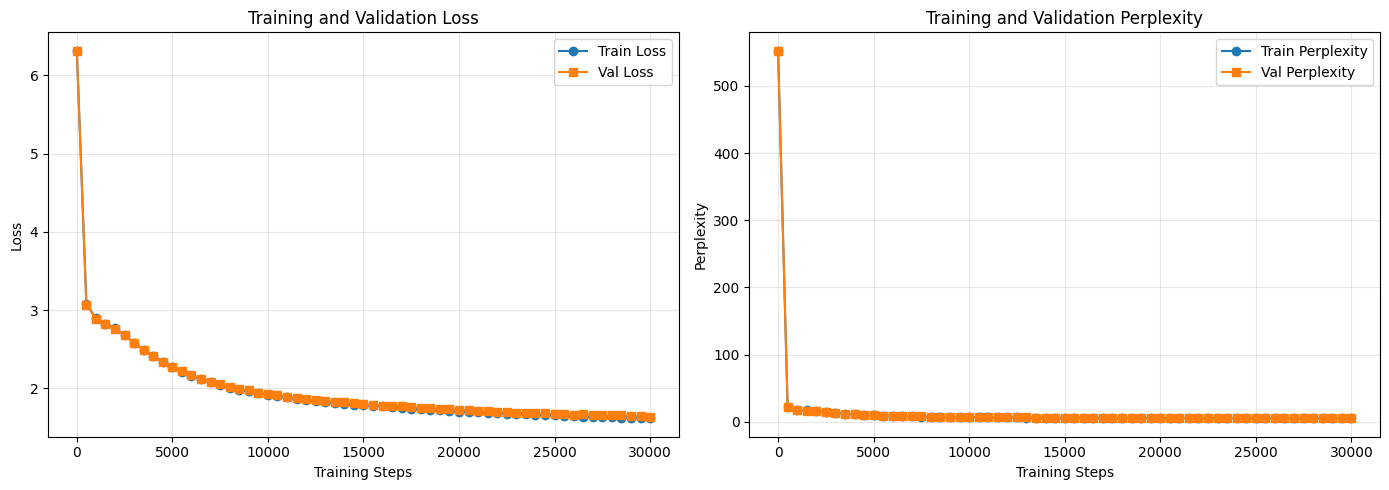

Training curves saved to 'training_curves.png'


In [20]:
# Plot training curves if we saved them
try:
    import matplotlib.pyplot as plt

    if len(train_losses) > 0 and len(val_losses) > 0:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

        # Loss curves
        steps = [i * eval_interval for i in range(len(train_losses))]
        ax1.plot(steps, train_losses, label='Train Loss', marker='o')
        ax1.plot(steps, val_losses, label='Val Loss', marker='s')
        ax1.set_xlabel('Training Steps')
        ax1.set_ylabel('Loss')
        ax1.set_title('Training and Validation Loss')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Perplexity curves
        train_ppls = [math.exp(loss) for loss in train_losses]
        val_ppls = [math.exp(loss) for loss in val_losses]
        ax2.plot(steps, train_ppls, label='Train Perplexity', marker='o')
        ax2.plot(steps, val_ppls, label='Val Perplexity', marker='s')
        ax2.set_xlabel('Training Steps')
        ax2.set_ylabel('Perplexity')
        ax2.set_title('Training and Validation Perplexity')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
        plt.show()
        print("Training curves saved to 'training_curves.png'")
except ImportError:
    print("Matplotlib not available. Install it to visualize training curves.")
except Exception as e:
    print(f"Could not plot training curves: {e}")

In [21]:
# Analyze grapheme distribution in generated vs. real text
def analyze_grapheme_distribution():
    """
    Compare grapheme frequency distribution between generated and real text.
    """
    print("\nGRAPHEME DISTRIBUTION ANALYSIS")
    print("=" * 80)

    # Get real text graphemes (sample)
    real_sample = all_graphemes[:10000]  # First 10k graphemes
    real_counts = Counter(real_sample)

    # Generate text
    model.eval()
    generated_graphemes = []
    for _ in range(5):
        context = torch.zeros((1, 1), dtype=torch.long, device=device)
        generated = model.generate(context, max_new_tokens=2000)
        graphemes = [itog[idx] for idx in generated[0].tolist()]
        generated_graphemes.extend(graphemes)

    gen_counts = Counter(generated_graphemes)

    # Compare top-20 most common graphemes
    print("\nTop 20 Most Common Graphemes:")
    print("-" * 80)
    print(f"{'Rank':<6} {'Grapheme':<12} {'Real %':<12} {'Generated %':<12} {'Difference':<12}")
    print("-" * 80)

    real_total = sum(real_counts.values())
    gen_total = sum(gen_counts.values())

    for rank, (grapheme, real_count) in enumerate(real_counts.most_common(20), 1):
        real_pct = (real_count / real_total) * 100
        gen_count = gen_counts.get(grapheme, 0)
        gen_pct = (gen_count / gen_total) * 100
        diff = gen_pct - real_pct

        print(f"{rank:<6} {grapheme:<12} {real_pct:>10.2f}% {gen_pct:>10.2f}% {diff:>+10.2f}%")

    # Calculate KL divergence (simplified)
    all_graphemes_set = set(real_counts.keys()) | set(gen_counts.keys())
    kl_div = 0
    for g in all_graphemes_set:
        p = (real_counts.get(g, 0) + 1) / (real_total + len(all_graphemes_set))  # Laplace smoothing
        q = (gen_counts.get(g, 0) + 1) / (gen_total + len(all_graphemes_set))
        kl_div += p * math.log(p / q)

    print(f"\nKL Divergence (Real || Generated): {kl_div:.4f}")
    print("(Lower is better - 0 means identical distributions)")
    print("=" * 80)

analyze_grapheme_distribution()


GRAPHEME DISTRIBUTION ANALYSIS

Top 20 Most Common Graphemes:
--------------------------------------------------------------------------------
Rank   Grapheme     Real %       Generated %  Difference  
--------------------------------------------------------------------------------
1                        15.07%      15.02%      -0.05%
2      க                  3.57%       3.73%      +0.16%
3      தி                 2.62%       2.02%      -0.60%
4      ர்                 2.37%       2.13%      -0.24%
5      த்                 2.18%       1.99%      -0.19%
6      க்                 2.13%       1.97%      -0.16%
7      ம்                 2.11%       2.07%      -0.04%
8      த                  2.02%       2.09%      +0.07%
9      ப                  1.96%       2.04%      +0.08%
10     ல்                 1.93%       2.11%      +0.18%
11     து                 1.90%       2.02%      +0.12%
12     வ                  1.75%       1.74%      -0.01%
13     ன்                 1.66%       1.94% 

In [22]:
# Check vocabulary statistics
print(f"\nVocabulary Statistics:")
print(f"Total unique graphemes: {vocab_size}")
print(f"Sample graphemes (first 30): {unique_graphemes[:30]}")
print(f"Sample graphemes (last 30): {unique_graphemes[-30:]}")


Vocabulary Statistics:
Total unique graphemes: 454
Sample graphemes (first 30): ['\n', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=']
Sample graphemes (last 30): ['ஸா', 'ஸி', 'ஸீ', 'ஸு', 'ஸூ', 'ஸெ', 'ஸொ', 'ஸே', 'ஸை', 'ஸொ', 'ஸோ', 'ஸ்', 'ஹ', 'ஹா', 'ஹி', 'ஹீ', 'ஹு', 'ஹூ', 'ஹெ', 'ஹே', 'ஹோ', 'ஹை', 'ஹொ', 'ஹோ', 'ஹ்', '‐', '–', '…', '\u2028', '\ue38d']


In [23]:
# Save comprehensive model info and metrics
model_info = {
    # Model architecture
    'vocab_size': vocab_size,
    'n_embd': n_embd,
    'n_head': n_head,
    'n_layer': n_layer,
    'block_size': block_size,
    'dropout': dropout,
    'total_params': sum(p.numel() for p in model.parameters()),

    # Training info
    'batch_size': batch_size,
    'learning_rate': learning_rate,
    'max_iters': max_iters,

    # Performance metrics
    'metrics': metrics,
}

import json
with open('grapheme_model_info.json', 'w', encoding='utf-8') as f:
    json.dump(model_info, f, indent=2, ensure_ascii=False)

print("\nModel info saved to grapheme_model_info.json")
print("\nModel Summary:")
print(json.dumps(model_info, indent=2, ensure_ascii=False))


Model info saved to grapheme_model_info.json

Model Summary:
{
  "vocab_size": 454,
  "n_embd": 96,
  "n_head": 3,
  "n_layer": 4,
  "block_size": 256,
  "dropout": 0.2,
  "total_params": 558598,
  "batch_size": 64,
  "learning_rate": 0.0002,
  "max_iters": 30000,
  "metrics": {
    "train_loss": 1.6119494611024856,
    "train_perplexity": 5.01257352624412,
    "val_loss": 1.6399694728851317,
    "val_perplexity": 5.155012142184854,
    "train_top1_accuracy": 0.5745782470703125,
    "train_top5_accuracy": 0.8218817138671874,
    "val_top1_accuracy": 0.570361328125,
    "val_top5_accuracy": 0.8181488037109375,
    "generation_entropy": 6.112243169905192,
    "generation_perplexity": 69.17808488941837,
    "unique_graphemes_used": 165,
    "diversity_score": 0.3634361233480176
  }
}
